# ADHD Clinical Trials: EDA and Predictive Modeling

This notebook provides an interactive exploration of ADHD clinical trial data and demonstrates the full machine learning pipeline for predicting trial success.

## Objectives

1. Fetch ADHD trial data from ClinicalTrials.gov
2. Perform exploratory data analysis (EDA)
3. Engineer features and create labels
4. Train and evaluate multiple ML models
5. Interpret results and identify key predictors

## Setup and Imports

In [31]:
import sys
import os

# Add parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src import fetch_data, prepare_data, train_models, utils

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Setup complete!")

Setup complete!


## Step 1: Fetch Data from ClinicalTrials.gov

We'll fetch ADHD Phase 2 and Phase 3 interventional trials using the ClinicalTrials.gov API.

In [32]:
# Fetch trials from API
trials = fetch_data.fetch_adhd_trials(max_results=2000, page_size=100)

print(f"\nFetched {len(trials)} trials")

Fetching ADHD interventional trials from ClinicalTrials.gov...
Page 1: Retrieved 100 trials (total: 100)
Page 2: Retrieved 100 trials (total: 200)
Page 3: Retrieved 100 trials (total: 300)
Page 4: Retrieved 100 trials (total: 400)
Page 5: Retrieved 100 trials (total: 500)
Page 6: Retrieved 18 trials (total: 518)
No more pages available.

Total trials retrieved: 518

Fetched 518 trials


In [33]:
# Save raw data
df_raw = fetch_data.save_data(trials)

print(f"\nRaw data shape: {df_raw.shape}")
df_raw.head()


Saved raw JSON to: data/raw/adhd_trials_raw.json

Filtered to Phase 2/3 trials: 41 trials
Saved filtered CSV to: data/raw/adhd_trials_raw.csv

DATA SUMMARY
Total trials (Phase 2/3): 41

Status distribution:
OverallStatus
COMPLETED                  26
UNKNOWN                     7
RECRUITING                  3
TERMINATED                  2
WITHDRAWN                   1
ACTIVE_NOT_RECRUITING       1
ENROLLING_BY_INVITATION     1
Name: count, dtype: int64

Phase distribution:
Phase
PHASE2            16
PHASE3            10
PHASE1, PHASE2    10
PHASE2, PHASE3     5
Name: count, dtype: int64

Sponsor class distribution:
LeadSponsorClass
OTHER        36
INDUSTRY      3
NIH           1
OTHER_GOV     1
Name: count, dtype: int64

Raw data shape: (41, 27)


,NCTId,BriefTitle,OfficialTitle,OverallStatus,StudyType,Phase,EnrollmentCount,StartDate,CompletionDate,LeadSponsorName,LeadSponsorClass,DesignAllocation,DesignInterventionModel,DesignPrimaryPurpose,DesignMasking,DesignMaskingDescription,NumberOfArms,InterventionType,InterventionName,PrimaryOutcomeMeasure,PrimaryOutcomeDescription,Condition,LocationCountry,MinimumAge,MaximumAge,Gender,HealthyVolunteers
3,NCT00057668,Preventing Behavior Problems in Children With ...,Prevention of Behavioral Deficits in Young ADH...,UNKNOWN,INTERVENTIONAL,PHASE2,200,2001-09,2006-08,Lehigh University,OTHER,RANDOMIZED,PARALLEL,TREATMENT,NONE,,NaN,BEHAVIORAL; BEHAVIORAL,Multi-Setting Early Intervention; Community In...,,,Attention Deficit Disorder With Hyperactivity,United States,3 Years,5 Years,ALL,True
17,NCT00506285,Methylphenidate Transdermal System (MTS) in th...,Methylphenidate Transdermal System (MTS) in th...,COMPLETED,INTERVENTIONAL,PHASE3,92,2007-06,2009-04,University of Utah,OTHER,RANDOMIZED,CROSSOVER,TREATMENT,QUADRUPLE,,2.0,DRUG; OTHER,Methylphenidate Transdermal System (MTS); plac...,Wender Reimherr Adult Attention Deficit Disord...,This scale measures the 7 domains of the Utah ...,Attention Deficit Hyperactivity Disorder,United States,18 Years,65 Years,ALL,False
25,NCT01913912,Event Rate and Effects of Stimulants in ADHD,Can Changing the Rate at Which Information is ...,WITHDRAWN,INTERVENTIONAL,PHASE3,0,2014-01,2014-01,University Ghent,OTHER,RANDOMIZED,CROSSOVER,OTHER,DOUBLE,,2.0,DRUG; DRUG; DEVICE; DEVICE; DEVICE,LDX.; sugar pill; computer task (Go/No-Go task...,Performance data (by using computerized Go-No ...,* mean reaction time (RT)\n* standard deviatio...,Attention Deficit Hyperactivity Disorder,Belgium,7 Years,12 Years,ALL,True
49,NCT01750996,Strongest Families Finland Canada: Family-base...,Strongest Families Finland Canada: Family-base...,COMPLETED,INTERVENTIONAL,"PHASE1, PHASE2",464,2011-10,2015-03,IWK Health Centre,OTHER,RANDOMIZED,PARALLEL,PREVENTION,TRIPLE,,2.0,BEHAVIORAL,Strongest Families,CHild Behaviour Checklist (to measure change f...,Measure of child behavioural change from basel...,Disruptive Behavior Disorder,Finland,4 Years,5 Years,ALL,True
67,NCT00368849,Atomoxetine and Huntington's Disease,Atomoxetine for Attention Deficits in Adults W...,COMPLETED,INTERVENTIONAL,PHASE2,20,2005-11,2008-02,University of Iowa,OTHER,RANDOMIZED,CROSSOVER,TREATMENT,QUADRUPLE,,2.0,DRUG; DRUG,atomoxetine; Matching Placebo,Conners' Adult Attention Rating Scale (CAARS);...,The Conners' Adult Attention Rating Scale (CAA...,Huntington Disease; Chorea,United States,18 Years,65 Years,ALL,False


## Step 2: Exploratory Data Analysis

Let's explore the raw data to understand trial characteristics and distributions.

In [34]:
# Data summary
summary = utils.get_data_summary(df_raw)
print("\nData Summary:")
summary


Data Summary:


,Type,Missing,Missing %,Unique,Sample Value
NCTId,object,0,0.00,41,NCT00057668
BriefTitle,object,0,0.00,41,Preventing Behavior Problems in Children With ...
OfficialTitle,object,0,0.00,41,Prevention of Behavioral Deficits in Young ADH...
OverallStatus,object,0,0.00,7,UNKNOWN
StudyType,object,0,0.00,1,INTERVENTIONAL
Phase,object,0,0.00,4,PHASE2
EnrollmentCount,int64,0,0.00,36,200
StartDate,object,0,0.00,39,2001-09
CompletionDate,object,0,0.00,41,2006-08
LeadSponsorName,object,0,0.00,36,Lehigh University



Trial Status Distribution:
OverallStatus
COMPLETED                  26
UNKNOWN                     7
RECRUITING                  3
TERMINATED                  2
WITHDRAWN                   1
ACTIVE_NOT_RECRUITING       1
ENROLLING_BY_INVITATION     1
Name: count, dtype: int64


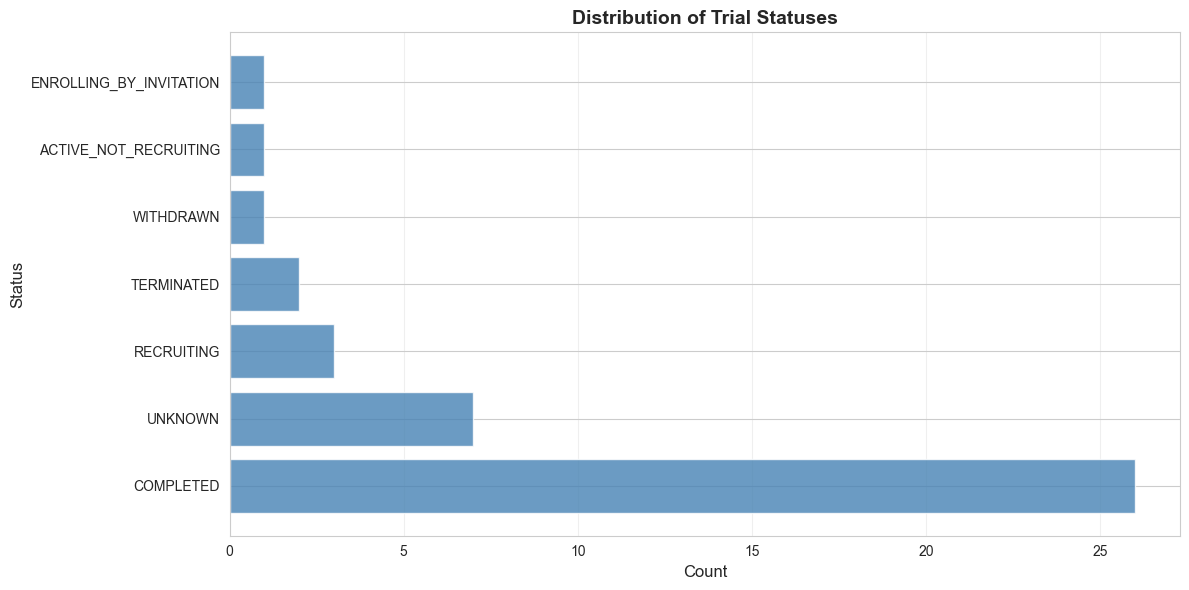

In [35]:
# Overall status distribution
print("\nTrial Status Distribution:")
print(df_raw['OverallStatus'].value_counts())

plt.figure(figsize=(12, 6))
status_counts = df_raw['OverallStatus'].value_counts()
plt.barh(range(len(status_counts)), status_counts.values, color='steelblue', alpha=0.8)
plt.yticks(range(len(status_counts)), status_counts.index)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.title('Distribution of Trial Statuses', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Phase Distribution:
Phase
PHASE2            16
PHASE3            10
PHASE1, PHASE2    10
PHASE2, PHASE3     5
Name: count, dtype: int64


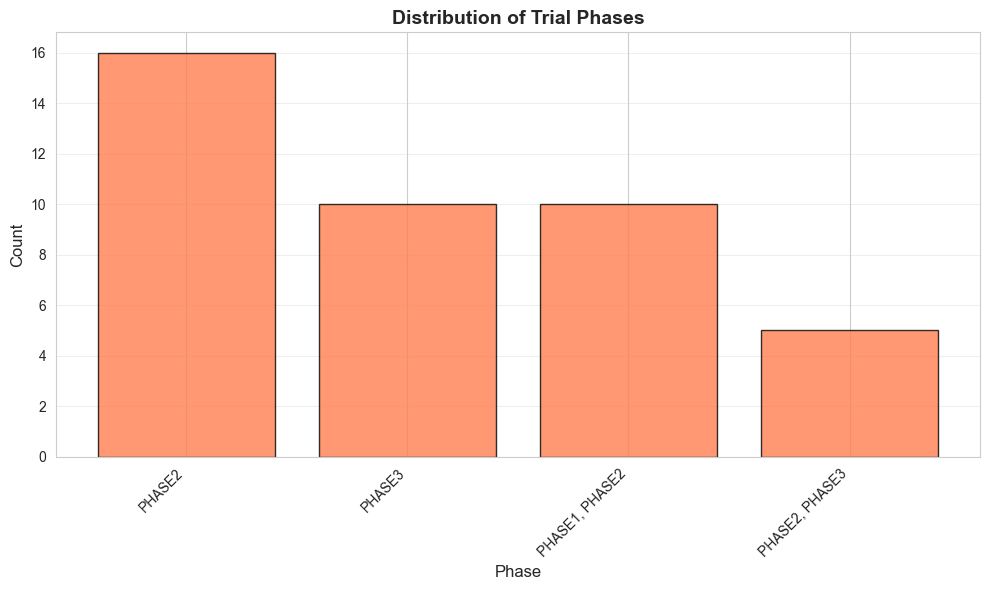

In [36]:
# Phase distribution
print("\nPhase Distribution:")
print(df_raw['Phase'].value_counts())

plt.figure(figsize=(10, 6))
phase_counts = df_raw['Phase'].value_counts()
plt.bar(range(len(phase_counts)), phase_counts.values, color='coral', alpha=0.8, edgecolor='black')
plt.xticks(range(len(phase_counts)), phase_counts.index, rotation=45, ha='right')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Phase', fontsize=12)
plt.title('Distribution of Trial Phases', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Sponsor Class Distribution:
LeadSponsorClass
OTHER        36
INDUSTRY      3
NIH           1
OTHER_GOV     1
Name: count, dtype: int64


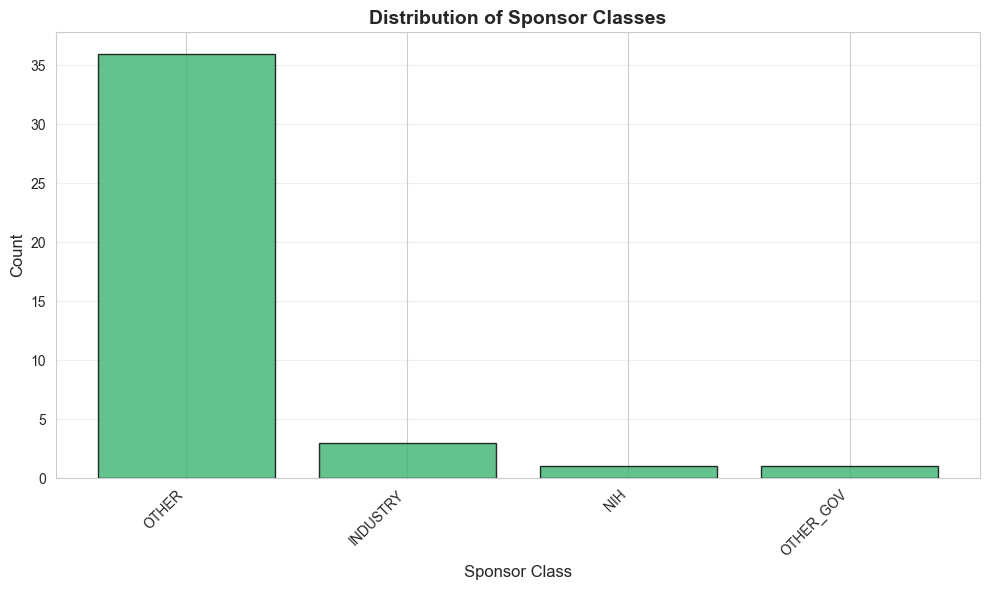

In [37]:
# Sponsor class distribution
print("\nSponsor Class Distribution:")
print(df_raw['LeadSponsorClass'].value_counts())

plt.figure(figsize=(10, 6))
sponsor_counts = df_raw['LeadSponsorClass'].value_counts()
plt.bar(range(len(sponsor_counts)), sponsor_counts.values, color='mediumseagreen', alpha=0.8, edgecolor='black')
plt.xticks(range(len(sponsor_counts)), sponsor_counts.index, rotation=45, ha='right')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sponsor Class', fontsize=12)
plt.title('Distribution of Sponsor Classes', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Enrollment Statistics:
Mean: 220.4
Median: 112.0
Min: 0
Max: 3190


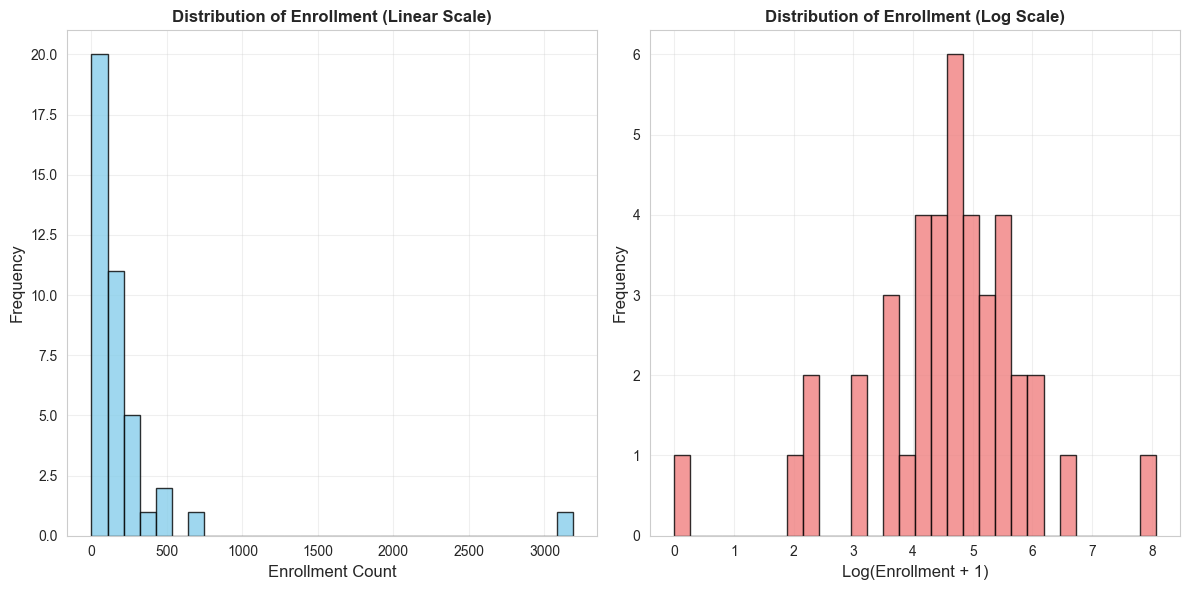

In [38]:
# Enrollment distribution
enrollment = pd.to_numeric(df_raw['EnrollmentCount'], errors='coerce').dropna()

print(f"\nEnrollment Statistics:")
print(f"Mean: {enrollment.mean():.1f}")
print(f"Median: {enrollment.median():.1f}")
print(f"Min: {enrollment.min():.0f}")
print(f"Max: {enrollment.max():.0f}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(enrollment, bins=30, color='skyblue', alpha=0.8, edgecolor='black')
plt.xlabel('Enrollment Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Enrollment (Linear Scale)', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(np.log1p(enrollment), bins=30, color='lightcoral', alpha=0.8, edgecolor='black')
plt.xlabel('Log(Enrollment + 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Enrollment (Log Scale)', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3: Data Preparation and Labeling

Create binary labels and engineer features for modeling.

In [39]:
# Create labels
df_labeled = prepare_data.create_binary_labels(df_raw)

print(f"\nLabeled data shape: {df_labeled.shape}")


LABEL DISTRIBUTION
Total labeled trials: 29
Successful (Completed): 26 (89.7%)
Failed (Terminated/Withdrawn/Suspended): 3 (10.3%)

Excluded 12 trials with statuses:
OverallStatus
UNKNOWN                    7
RECRUITING                 3
ACTIVE_NOT_RECRUITING      1
ENROLLING_BY_INVITATION    1
Name: count, dtype: int64

Labeled data shape: (29, 28)


In [40]:
# Visualize class distribution
utils.plot_class_distribution(df_labeled, save_path='../data/processed/class_distribution.png')
plt.show()

Class distribution plot saved to: ../data/processed/class_distribution.png


In [41]:
# Engineer features
df_features = prepare_data.engineer_features(df_labeled)

print(f"\nData with features shape: {df_features.shape}")


FEATURE ENGINEERING
Created 59 features

Data with features shape: (29, 62)


In [42]:
# Select final features
df_final, feature_cols = prepare_data.select_modeling_features(df_features)

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")


FINAL DATASET
Total samples: 29
Total features: 32
Missing values per feature:
  No missing values!

Final dataset shape: (29, 36)
Number of features: 32

Feature list:
 1. EnrollmentCount
 2. LogEnrollment
 3. SmallTrial
 4. LargeTrial
 5. IsPhase2
 6. IsPhase3
 7. IsPhase2And3
 8. IsRandomized
 9. IsDoubleBlind
10. IsBlinded
11. NumberOfArms
12. HasMultipleArms
13. NumArms_2
14. NumArms_3Plus
15. IsParallelAssignment
16. IsCrossover
17. IsDrugIntervention
18. IsBehavioralIntervention
19. IsDeviceIntervention
20. NumInterventions
21. IsIndustrySponsored
22. IsNIHSponsored
23. IsAcademicSponsored
24. NumCountries
25. IsMultiCountry
26. IsUSOnly
27. IncludesChildren
28. IncludesAdults
29. AllGenders
30. AcceptsHealthyVolunteers
31. IsTreatmentPurpose
32. IsPreventionPurpose


In [43]:
# Save processed data
prepare_data.save_processed_data(df_final)

print("\nProcessed data saved!")


Saved processed data to: data/processed/adhd_trials_labeled.csv

Processed data saved!


## Step 4: Feature Analysis

Analyze relationships between features and the target variable.

In [44]:
# Success rate by sponsor class
sponsor_summary = utils.create_summary_table(df_final, 'OverallStatus', 'Label')
print("\nSuccess Rate by Status:")
print(sponsor_summary)


Success Rate by Status:
               Total_Trials  Successes  Success_Rate
OverallStatus                                       
COMPLETED                26         26           1.0
TERMINATED                2          0           0.0
WITHDRAWN                 1          0           0.0


In [45]:
# Plot feature distributions by outcome
numeric_features = [col for col in feature_cols if df_final[col].dtype in [np.float64, np.int64]]
utils.plot_feature_distributions(
    df_final, 
    numeric_features, 
    save_path='../data/processed/feature_distributions.png'
)
plt.show()

Feature distributions plot saved to: ../data/processed/feature_distributions.png


In [46]:
# Correlation matrix
utils.plot_correlation_matrix(
    df_final, 
    feature_cols, 
    save_path='../data/processed/correlation_matrix.png'
)
plt.show()

Correlation matrix plot saved to: ../data/processed/correlation_matrix.png


## Step 5: Model Training and Evaluation

Train multiple models and compare their performance.

In [47]:
# Prepare train/test split
X_train, X_test, y_train, y_test, train_idx, test_idx = train_models.prepare_train_test_split(
    df_final, feature_cols, test_size=0.2, random_state=42
)


TRAIN/TEST SPLIT
Training samples: 23 (79.3%)
  Success: 21 (91.3%)
  Failure: 2 (8.7%)

Test samples: 6 (20.7%)
  Success: 5 (83.3%)
  Failure: 1 (16.7%)


In [48]:
# Scale features
X_train_scaled, X_test_scaled, scaler = train_models.scale_features(X_train, X_test)


Features standardized (mean=0, std=1)


In [49]:
# Train models
models = train_models.train_models(X_train_scaled, y_train, random_state=42)


TRAINING MODELS

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...

Trained 3 models


In [50]:
# Evaluate models
results_df = train_models.evaluate_all_models(
    models, X_train_scaled, y_train, X_test_scaled, y_test
)

print("\nModel Performance Comparison:")
results_df


MODEL EVALUATION

Evaluating Logistic Regression...

Evaluating Random Forest...

Evaluating Gradient Boosting...

MODEL COMPARISON (Test Set)
                     test_accuracy  test_precision  test_recall  test_f1  \
Logistic Regression          0.833           0.833          1.0    0.909   
Random Forest                0.833           0.833          1.0    0.909   
Gradient Boosting            0.833           0.833          1.0    0.909   

                     test_auc  
Logistic Regression       0.6  
Random Forest             0.4  
Gradient Boosting         0.5  

Model Performance Comparison:


,test_accuracy,test_precision,test_recall,test_f1,test_auc,train_accuracy,train_precision,train_recall,train_f1,train_auc
Logistic Regression,0.833333,0.833333,1.0,0.909091,0.6,1.0,1.0,1.0,1.0,1.0
Random Forest,0.833333,0.833333,1.0,0.909091,0.4,1.0,1.0,1.0,1.0,1.0
Gradient Boosting,0.833333,0.833333,1.0,0.909091,0.5,1.0,1.0,1.0,1.0,1.0


In [51]:
# Calculate baseline
baseline = utils.calculate_baseline_metrics(y_test)
print("\nBaseline (Majority Class) Performance:")
for metric, value in baseline.items():
    print(f"  {metric}: {value:.3f}")


Baseline (Majority Class) Performance:
  accuracy: 0.833
  precision: 0.833
  recall: 1.000
  f1: 0.909


## Step 6: Model Visualization and Interpretation

In [52]:
# Plot ROC curves
train_models.plot_roc_curves(
    models, X_test_scaled, y_test, 
    save_path='../data/processed/roc_curves.png'
)
plt.show()


ROC curves saved to: ../data/processed/roc_curves.png


In [53]:
# Feature importance for Random Forest
train_models.plot_feature_importance(
    models['Random Forest'], 
    feature_cols, 
    'Random Forest',
    top_n=20,
    save_path='../data/processed/feature_importance.png'
)
plt.show()

Feature importance plot saved to: ../data/processed/feature_importance_random_forest.png


In [54]:
# Get top features
top_features = utils.get_top_features_by_importance(
    models['Random Forest'], 
    feature_cols, 
    top_n=15
)
print("\nTop 15 Most Important Features (Random Forest):")
print(top_features)


Top 15 Most Important Features (Random Forest):
                 Feature  Importance
0        EnrollmentCount    0.165720
1             SmallTrial    0.152174
2       NumInterventions    0.123879
3     IsTreatmentPurpose    0.114460
4          LogEnrollment    0.101066
5          IsDoubleBlind    0.056883
6     IsDrugIntervention    0.050395
7    IsIndustrySponsored    0.045654
8   IsDeviceIntervention    0.040989
9              IsBlinded    0.037871
10           IsCrossover    0.024274
11              IsUSOnly    0.019095
12             NumArms_2    0.018774
13         NumArms_3Plus    0.010995
14  IsParallelAssignment    0.010870


In [55]:
# Confusion matrix for best model
best_model_name = results_df['test_auc'].idxmax()
best_model = models[best_model_name]

print(f"\nBest model by AUC: {best_model_name}")

train_models.plot_confusion_matrix(
    best_model, X_test_scaled, y_test, best_model_name,
    save_path='../data/processed/confusion_matrix.png'
)
plt.show()


Best model by AUC: Logistic Regression
Confusion matrix saved to: ../data/processed/confusion_matrix_logistic_regression.png


In [56]:
# Classification report
y_pred = best_model.predict(X_test_scaled)
utils.print_classification_summary(y_test, y_pred, best_model_name)


Logistic Regression - Classification Report
              precision    recall  f1-score   support

 Failure (0)      0.000     0.000     0.000         1
 Success (1)      0.833     1.000     0.909         5

    accuracy                          0.833         6
   macro avg      0.417     0.500     0.455         6
weighted avg      0.694     0.833     0.758         6



/Users/lindsaygross/ME AIPI Code/AIPI520/aipi520_repo/ADHDTrials/ADHD_clinical_trials/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lindsaygross/ME AIPI Code/AIPI520/aipi520_repo/ADHDTrials/ADHD_clinical_trials/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/lindsaygross/ME AIPI Code/AIPI520/aipi520_repo/ADHDTrials/ADHD_clinical_trials/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is 

## Step 7: Error Analysis

Examine cases where the model made incorrect predictions.

In [57]:
# Create predictions dataframe
# Use .loc instead of .iloc since test_idx contains actual index values, not positions
test_df = df_final.loc[test_idx].copy()
test_df['Predicted'] = y_pred
test_df['Correct'] = test_df['Label'] == test_df['Predicted']
test_df['Probability_Success'] = best_model.predict_proba(X_test_scaled)[:, 1]

# False positives (predicted success, actually failed)
false_positives = test_df[(test_df['Label'] == 0) & (test_df['Predicted'] == 1)]
print(f"\nFalse Positives: {len(false_positives)}")
if len(false_positives) > 0:
    print("\nSample False Positives:")
    print(false_positives[['NCTId', 'BriefTitle', 'OverallStatus', 'Probability_Success']].head())

# False negatives (predicted failure, actually succeeded)
false_negatives = test_df[(test_df['Label'] == 1) & (test_df['Predicted'] == 0)]
print(f"\nFalse Negatives: {len(false_negatives)}")
if len(false_negatives) > 0:
    print("\nSample False Negatives:")
    print(false_negatives[['NCTId', 'BriefTitle', 'OverallStatus', 'Probability_Success']].head())


False Positives: 1

Sample False Positives:
           NCTId                                         BriefTitle  \
374  NCT02502799  Intervention for Teens With ADHD and Substance...   

    OverallStatus  Probability_Success  
374    TERMINATED             0.982004  

False Negatives: 0


## Summary and Conclusions

This notebook demonstrated:

1. **Data Collection**: Fetched ADHD Phase 2/3 trials from ClinicalTrials.gov
2. **Data Preparation**: Created binary labels and engineered 34 features
3. **Model Training**: Trained 3 models (Logistic Regression, Random Forest, Gradient Boosting)
4. **Evaluation**: Compared models using accuracy, precision, recall, F1, and AUC
5. **Interpretation**: Identified key predictors of trial success

### Key Findings

- Model performance suggests trial design characteristics are moderately predictive of success
- Important features typically include enrollment size, randomization, blinding, and sponsor type
- Class imbalance (most trials succeed) affects prediction of failures

### Next Steps

- Explore additional feature engineering (text analysis, temporal features)
- Tune hyperparameters for improved performance
- Validate on trials from other therapeutic areas
- Develop interpretable insights for trial design recommendations